In [1]:
import os
import numpy as np
from PIL import Image
from PIL.ImageStat import Stat
from PIL import ImageChops as ops
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [674]:
im_list = [Image.open(os.path.join('dev_dataset', img)) for img in os.listdir('dev_dataset') if not os.path.isdir(img)]

# FEATURE GENERATION

In [539]:
def dct_transform(matrix):
    dct = np.zeros(shape=matrix.shape) 
    m, n = matrix.shape

    for i in range(matrix.shape[0]): 
        for j in range(matrix.shape[1]):
            
            if i == 0:
                ci = 1 / np.sqrt(m) 
            else:
                ci = np.sqrt(2 / m)
                
            if j == 0: 
                cj = 1 / np.sqrt(n) 
            else:
                cj = np.sqrt(2 / n)
            
            s = 0
            for k in range(m):
                for l in range(n):
                    s += (matrix[k, l] *  
                           np.cos((2 * k + 1) * i * np.pi / (2 * m)) *  
                           np.cos((2 * l + 1) * j * np.pi / (2 * n)))
            dct[i, j] = ci * cj * s
    return dct

def p_hash(im):
    d = np.array(im.resize((32, 32)).convert('L'))
    dct = dct_transform(d)[:8, :8]
    
    return (dct.ravel() > dct[1:].mean()).astype(np.int32)

def average_hash(im, size):
    d = np.array(im.resize((size, size)).convert('L'))
    
    return (d.ravel() > d.mean()).astype(np.int32)

def d_hash(im, size):
    d = np.array(im.resize((size + 1, size)).convert('L'))
    
    return (d[:, 1:] > d[:, :-1]).ravel().astype(np.int32)

def dv_hash(im, size):
    d = np.array(im.resize((size, size + 1)).convert('L'))
    
    return (d[1:, :] > d[:-1, :]).ravel().astype(np.int32)

def hamming_distance(h1, h2):
    return np.sum(h1 != h2)

In [664]:
def stats(a):
    i0 = (a[0, 0] + a[0, 1] + a[1, 0] + a[1, 1])/4
    i1 = 128 + (a[0, 0] - a[0, 1] + a[1, 0] - a[1, 1])/4
    i2 = 128 + (a[0, 0] + a[0, 1] - a[1, 0] - a[1, 1])/4
    i3 = 128 + (a[0, 0] - a[0, 1] - a[1, 0] + a[1, 1])/4
    
    return np.stack([i0, i1, i2, i3])

def rms(a, b):
    return np.sqrt(np.power(a - b, 2).mean())

def calc_stats(im1, im2):
    ph = []
    or1 = im1.convert('L')
    or2 = im2.convert('L')
    ds1 = or1.resize((1024, 1024))
    ds2 = or2.resize((1024, 1024))

    ph.append(np.abs(stats(np.array(or1.resize((2, 2)), dtype=np.float32)) -
              stats(np.array(or2.resize((2, 2)), dtype=np.float32))))
    ph.append([rms(np.array(ds1), np.array(ds2))])
    ph.append([np.abs(Stat(or1).mean[0] - Stat(or2).mean[0])])
    ph.append([np.abs(Stat(or1).stddev[0] - Stat(or2).stddev[0])])

    ph.append(Stat(ops.lighter(ds1, ds2)).mean)
    ph.append(Stat(ops.darker(ds1, ds2)).mean)
    ph.append(Stat(ops.lighter(ds1, ds2)).stddev)
    ph.append(Stat(ops.darker(ds1, ds2)).stddev)
#     ph.append(hamming_distance(d_hash(im_list[i], 32), d_hash(im_list[j], 32)))
#     ph.append(hamming_distance(dv_hash(im_list[i], 32), dv_hash(im_list[j], 32)))

    ph.append([np.abs(or1.size[0] / or1.size[1] - or2.size[0] / or2.size[1])])
    return np.hstack(ph)

In [561]:
fnames = ['stats1', 'stats2', 'stats3', 'stats4', 'rms', 'mean_diff', 'std_diff',
          'l_mean', 'd_mean', 'l_std', 'd_std', 'd_hash', 'dv_hash', 'size_diff']
features = []
for i in range(len(im_list)):
    for j in range(len(im_list)):
        ph = calc_stats(im_list[i], im_list[j])

        n1 = im_list[i].filename.split('/')[-1].split('.')[0].split('_')
        n2 = im_list[j].filename.split('/')[-1].split('.')[0].split('_')
        if n1[0] == n2[0]:
            ph = np.append(ph, [1])
        else:
            ph = np.append(ph, [0])

        features.append(np.hstack(ph))
features = np.vstack(features)
print(features.shape)

(1681, 15)


# IMAGES

In [189]:
or1 = im_list[11].convert('L')
or2 = im_list[17].convert('L')
ds1 = or1.resize((1024, 1024))
ds2 = or2.resize((1024, 1024))
im1 = np.array(or1.resize((2, 2)), dtype=np.float32)
im2 = np.array(or2.resize((2, 2)), dtype=np.float32)

In [190]:
print('STATS')
print(stats(im1), stats(im2))
print(rms(np.array(ds1), np.array(ds2)))
print('Mean', Stat(or1).mean, Stat(or2).mean)
print('Stddev', Stat(or1).stddev, Stat(or2).stddev)

print('\nMODIFIED: Lighter/Darker')
print('Mean', Stat(ops.lighter(ds1, ds2)).mean, Stat(ops.darker(ds1, ds2)).mean)
print('Stddev', Stat(ops.lighter(ds1, ds2)).stddev, Stat(ops.darker(ds1, ds2)).stddev)

print('\nSIZES')
print(or1.size[0] / or1.size[1], or2.size[0] / or2.size[1])

STATS
[ 53.5 104.  117.  131.5] [156.  107.5 191.  143.5]
10.168991453637036
Mean [67.49599076111554] [91.59398765968002]
Stddev [36.8055851072787] [61.973286232887325]

MODIFIED: Lighter/Darker
Mean [108.1798963546753] [50.91500282287598]
Stddev [54.60967310441704] [29.32996016830343]

SIZES
1.4817204301075269 1.500682128240109


# PLOTS

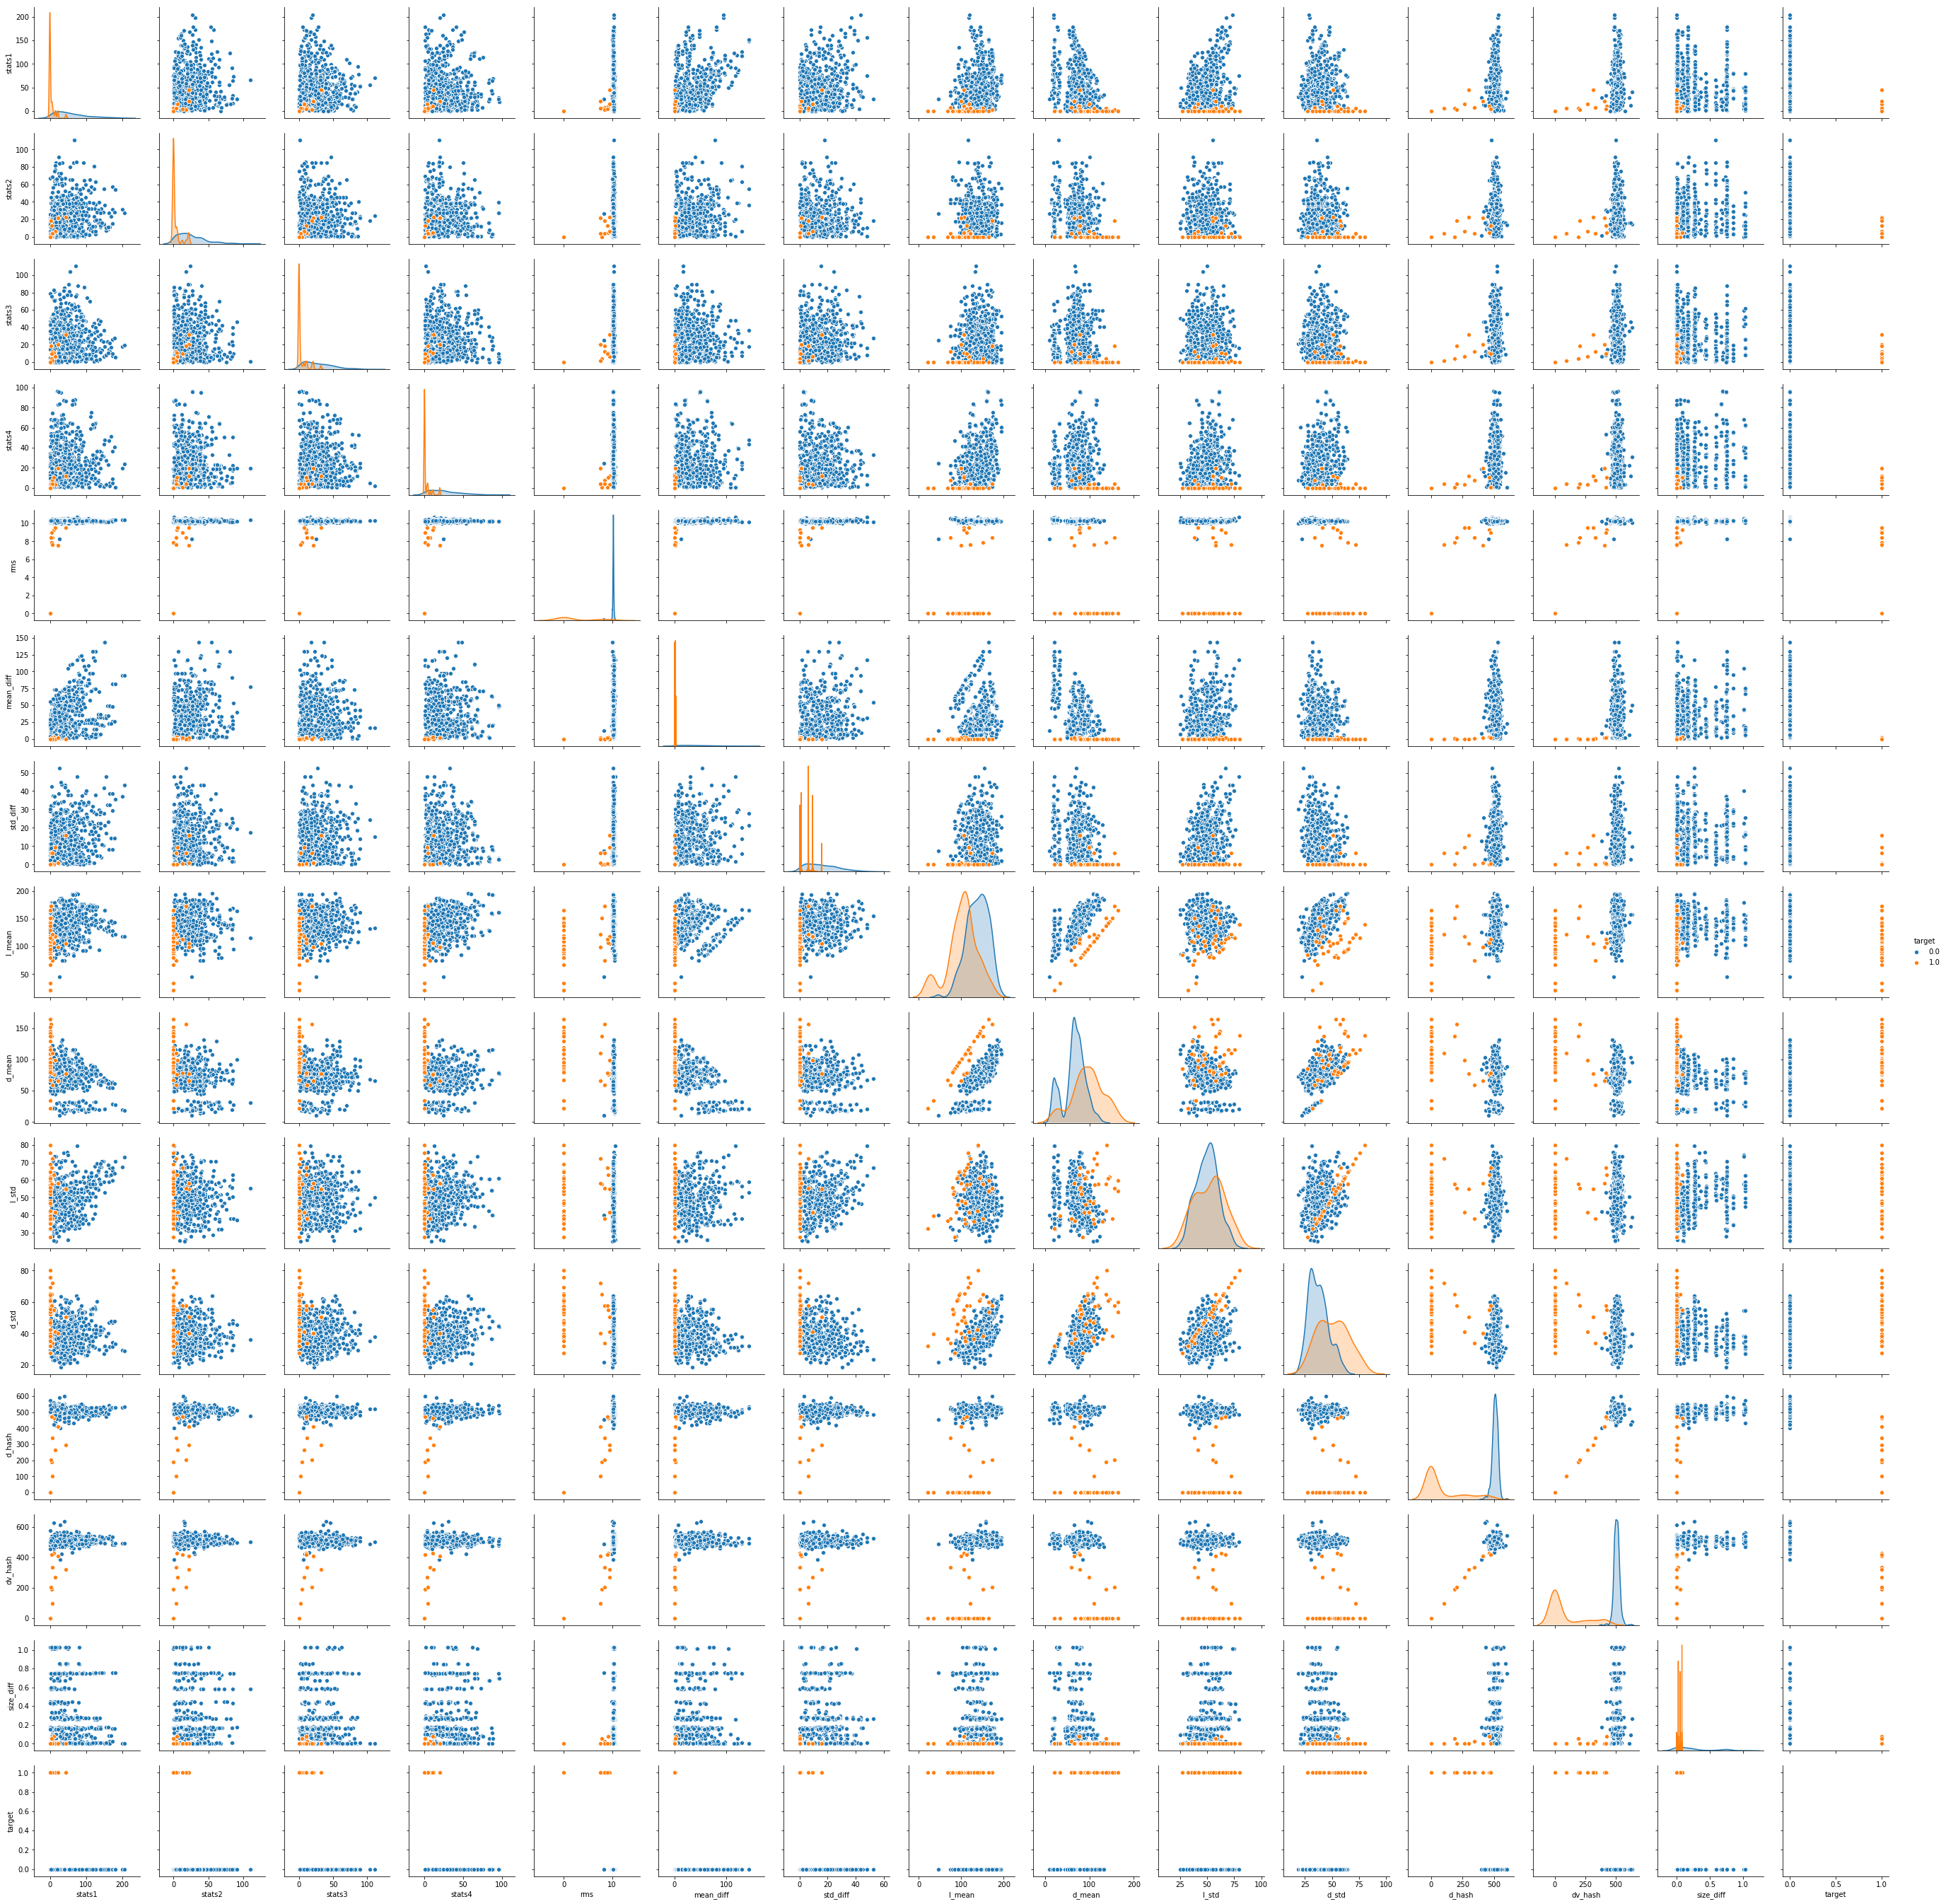

In [565]:
c = fnames.copy()
c.append('target')
df = pd.DataFrame(data=features, columns=c)
pplt = sns.pairplot(df, hue='target')

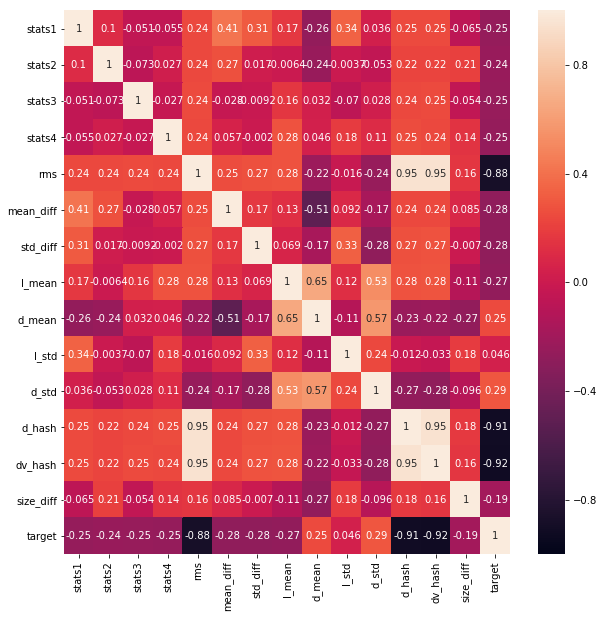

In [566]:
plt.figure(figsize=(10, 10))
hm = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

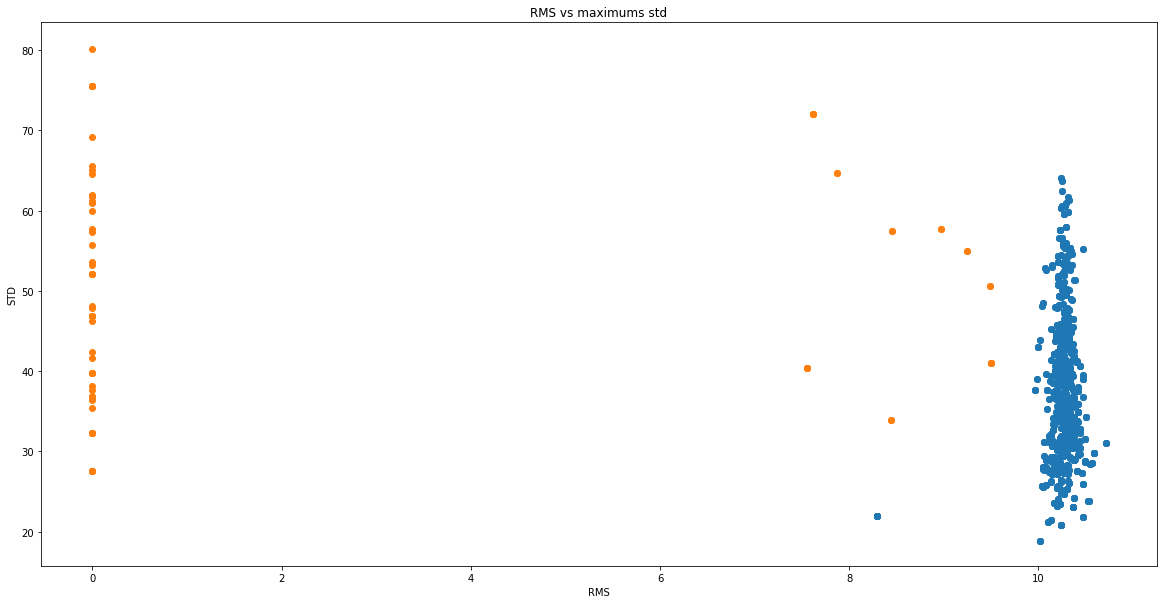

In [568]:
# RMS vs darker_std
plt.figure(figsize=(20, 10))
plt.title('RMS vs maximums std')
plt.xlabel('RMS')
plt.ylabel('STD')
plt.scatter(features[features[:, -1] == 0][:, 4], features[features[:, -1] == 0][:, 10])
plt.scatter(features[features[:, -1] == 1][:, 4], features[features[:, -1] == 1][:, 10])

<Figure size 1440x720 with 0 Axes>

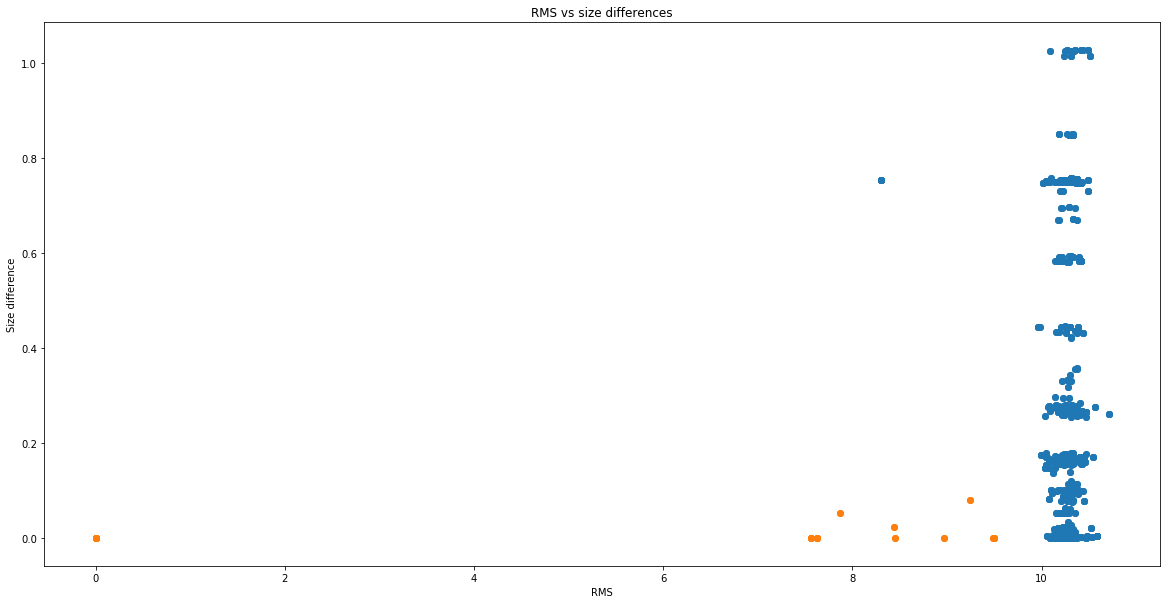

In [571]:
# RMS vs size_diffrence
plt.figure(figsize=(20, 10))
plt.figure(figsize=(20, 10))
plt.title('RMS vs size differences')
plt.xlabel('RMS')
plt.ylabel('Size difference')
plt.scatter(features[features[:, -1] == 0][:, 4], features[features[:, -1] == 0][:, 13])
plt.scatter(features[features[:, -1] == 1][:, 4], features[features[:, -1] == 1][:, 13])

# MODELS

## Rule-based

In [299]:
def classify_rulebased(im1, im2):
    or1 = im1.convert('L')
    or2 = im2.convert('L')
    ds1 = or1.resize((1024, 1024))
    ds2 = or2.resize((1024, 1024))

    err = rms(np.array(ds1), np.array(ds2))
    size_diff = np.abs(or1.size[0] / or1.size[1] - or2.size[0] / or2.size[1])
    d_std = Stat(ops.darker(ds1, ds2)).stddev[0]

    if err < 9.8 and (err == 0 or size_diff < 0.5 or d_std > 28):
        return True
    else:
        return False

## Logistic Regression

In [572]:
def predict(x, w):
    p = x.dot(w)
    return 1. / (1. + np.exp(-p))

def train(x, y, ep, l_rate=0.1, l=0.1, reg='l1'):
    m = x.shape[0]
    x_ = np.ones((m, x.shape[1] + 1), dtype=np.float32)
    x_[:, 1:] = x
    w = np.random.normal(scale=1e-6, size=(x_.shape[1], 1)).astype(np.float32)
    
    for i in range(ep):
        e = x_.transpose().dot(predict(x_, w) - y)
        
        if reg == 'l1':
            reg_p = l * np.sign(w)
        elif reg == 'l2':
            reg_p = l * w
        else:
            reg_p = 0
        
        w = w - l_rate * (e + reg_p) / m
        
    return w

def classify_regression(im1, im2, thr=0.6):
    w = np.array([0.0007282, -0.01936689, -0.01438374, -0.039445,
                  -0.05667355, -0.0250665, -0.13507414, -0.07393462,
                  -0.15777153, 0.13417615, 0.1085812, 0.12869122, -0.00268428],
                 dtype=np.float32)
    X = np.hstack([[1], calc_stats(im1, im2)])
    return predict(X, w) > thr

In [573]:
X = features[:, :-1]
y = features[:, -1].reshape((-1, 1))
epochs = 1000
r = 0.04
l = 100

In [577]:
theta0 = train(X, y, epochs, r, l, reg='l1')
theta1 = train(X, y, epochs, r, l, reg='l2')
theta2 = train(X, y, epochs, r, l, reg=None)

/home/vvrud/anaconda3/envs/data_science/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [578]:
X_hat = np.ones((X.shape[0], X.shape[1] + 1), dtype=np.float32)
X_hat[:, 1:] = X

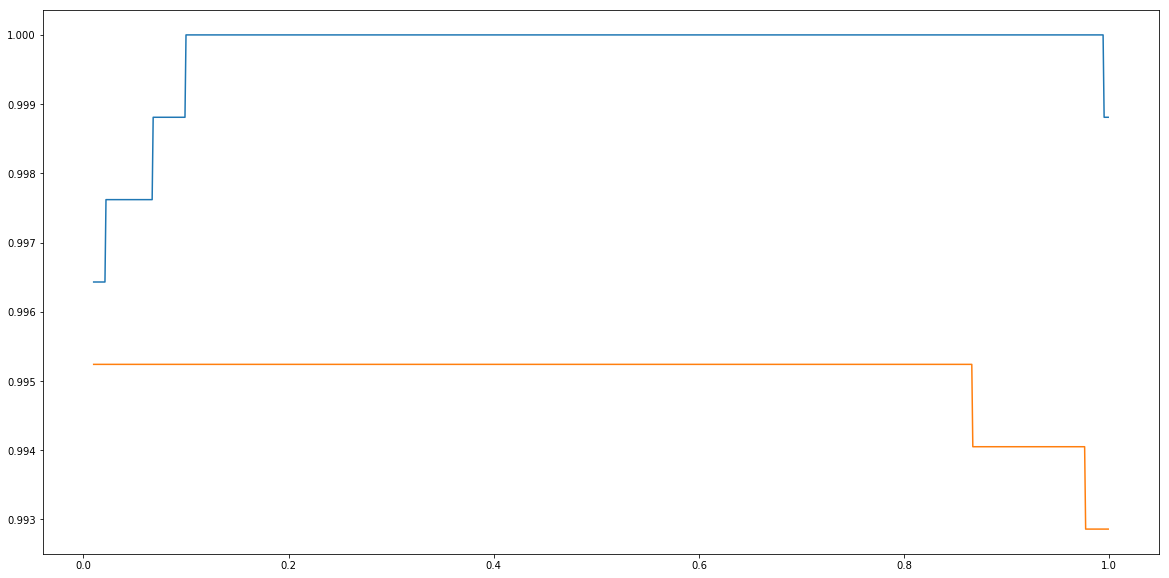

In [579]:
step = 0.001
y_p = predict(X_hat, theta0)
y_p1 = predict(X_hat, theta1)
y_p2 = predict(X_hat, theta2)
st = []
st1 = []
st2 = []

for i in np.arange(0.01, 1, step):
    st.append(accuracy_score(y, (y_p >= i).astype(np.int32)))
    st1.append(accuracy_score(y, (y_p1 >= i).astype(np.int32)))
    st2.append(accuracy_score(y, (y_p2 >= i).astype(np.int32)))

plt.figure(figsize=(20, 10))
plt.plot(np.arange(0.01, 1, step), st)
plt.plot(np.arange(0.01, 1, step), st1)
# plt.plot(np.arange(0.01, 1, step), st2)

In [581]:
theta1

array([[ 0.0303969 ],
       [-0.53782024],
       [-0.35400369],
       [-0.35207729],
       [-0.57873706],
       [ 0.08331788],
       [-0.90350449],
       [-0.51568143],
       [ 0.14972203],
       [ 1.60196757],
       [ 1.98941903],
       [ 1.41313612],
       [-0.01344735],
       [-0.80763054],
       [-0.00698198]])

# Hash-based

In [553]:
feat = []
ph = []

for d in [16, 32]:    
    dist = []
    for i in range(len(im_list)):
        for j in range(i+1, len(im_list)):
            d1 = hamming_distance(average_hash(im_list[i], d), average_hash(im_list[j], d))
            d2 = hamming_distance(d_hash(im_list[i], d), d_hash(im_list[j], d))
            d3 = hamming_distance(dv_hash(im_list[i], d), dv_hash(im_list[j], d))
            dist.append([d1, d2, d3])
    feat.append(np.vstack(dist))
    
# ims_h = [p_hash(im) for im in im_list]
for i in range(len(im_list)):
    for j in range(i+1, len(im_list)):
        n1 = im_list[i].filename.split('/')[-1].split('.')[0].split('_')
        n2 = im_list[j].filename.split('/')[-1].split('.')[0].split('_')
#         d1 = hamming_distance(ims_h[i], ims_h[j])
        if n1[0] == n2[0]:
            ph.append([d1, 1])
        else:
            ph.append([d1, 0])

feat.append(np.vstack(ph))
feat = np.hstack(feat)

In [660]:
def classify_hashbased(im1, im2):
    avg = hamming_distance(average_hash(im1, 32), average_hash(im2, 32))
    dv = hamming_distance(dv_hash(im1, 32), dv_hash(im2, 32))
    if avg < 300 and d < 475:
        return True
    else:
        return False

/home/vvrud/anaconda3/envs/data_science/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/vvrud/anaconda3/envs/data_science/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


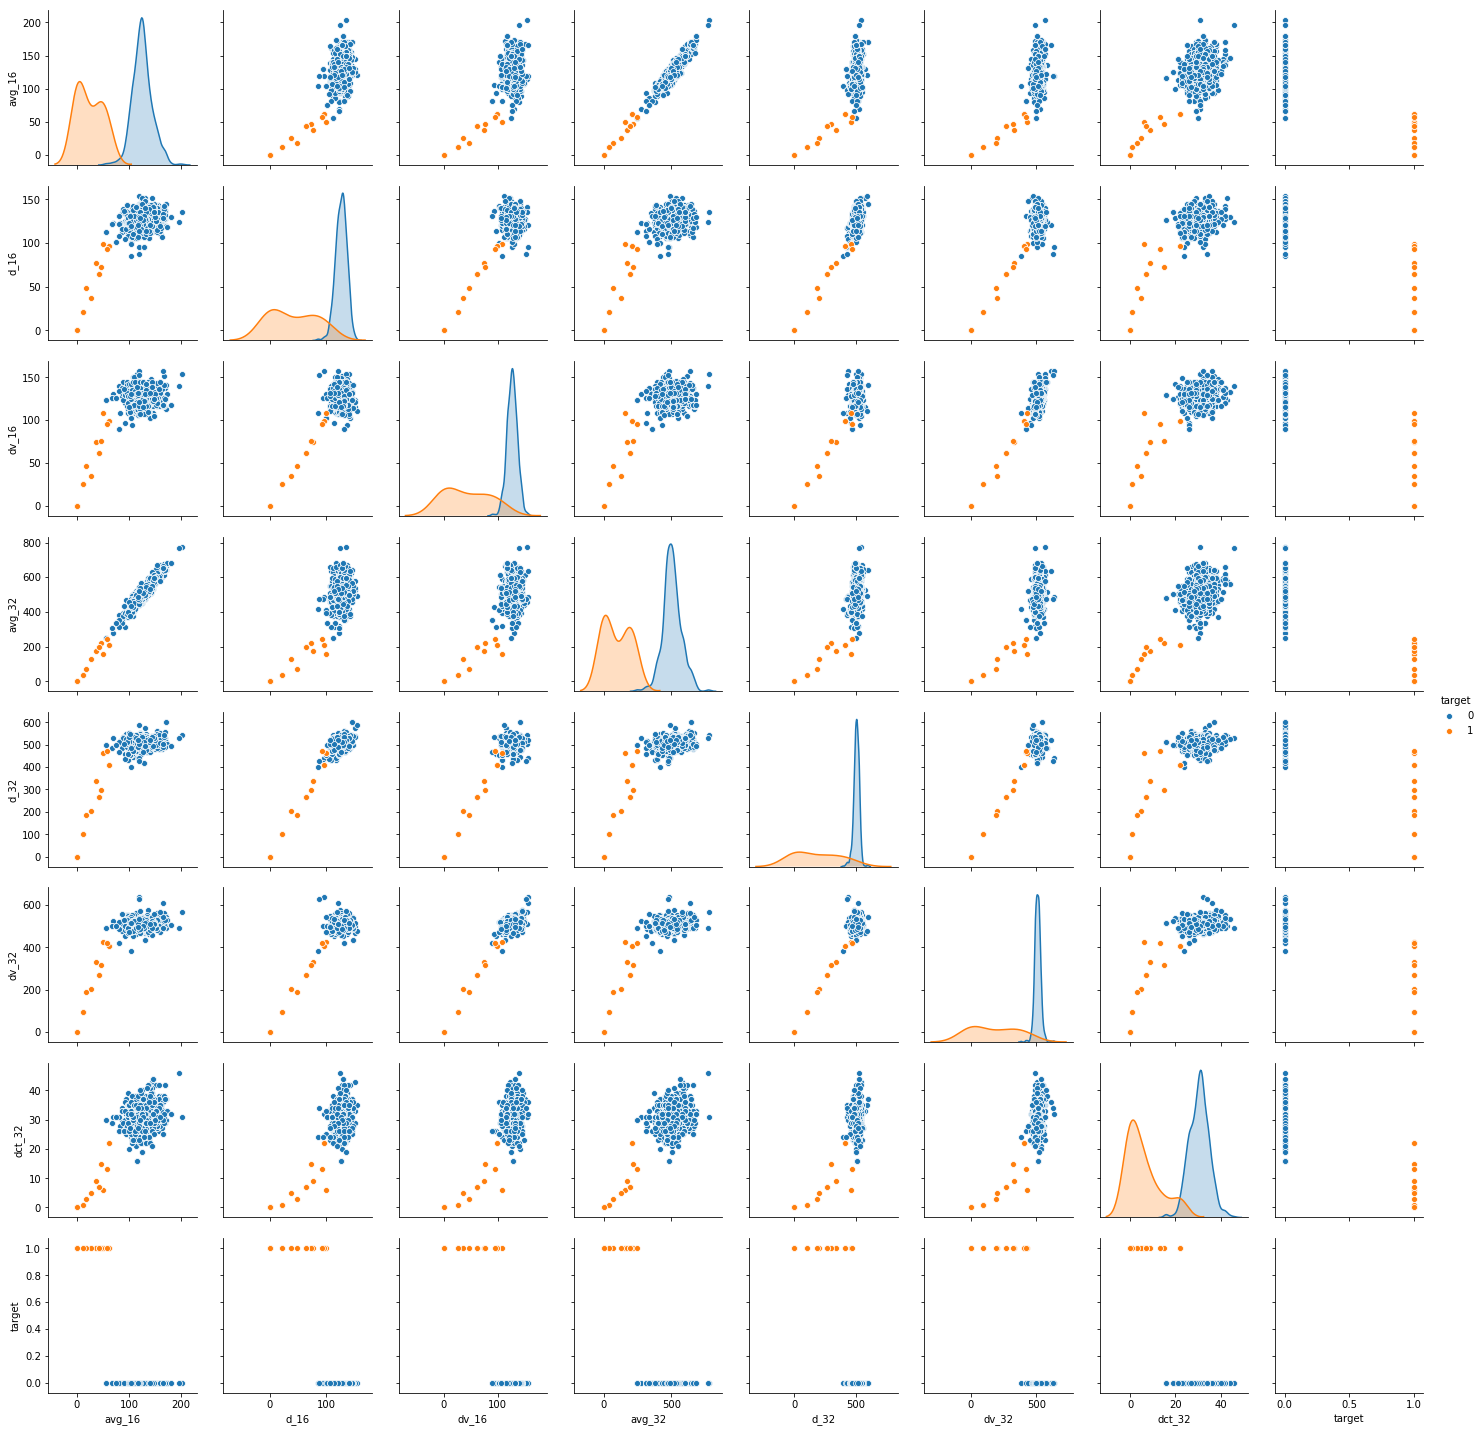

In [554]:
df = pd.DataFrame(feat, columns=['avg_16', 'd_16', 'dv_16', 'avg_32', 'd_32',  'dv_32', 'dct_32', 'target'])
sns.pairplot(df, hue='target')

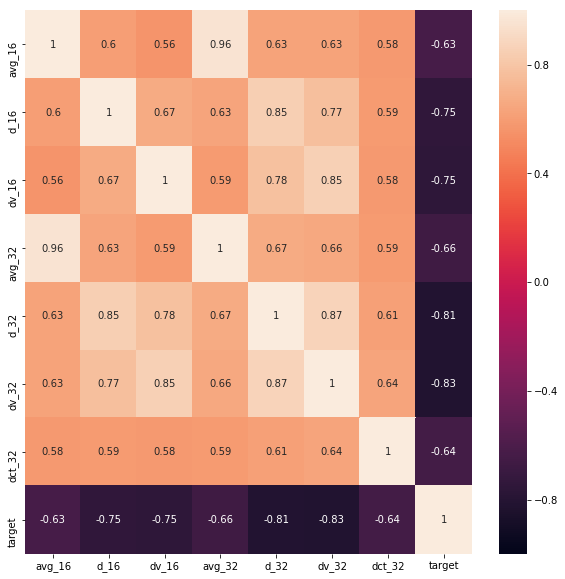

In [555]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

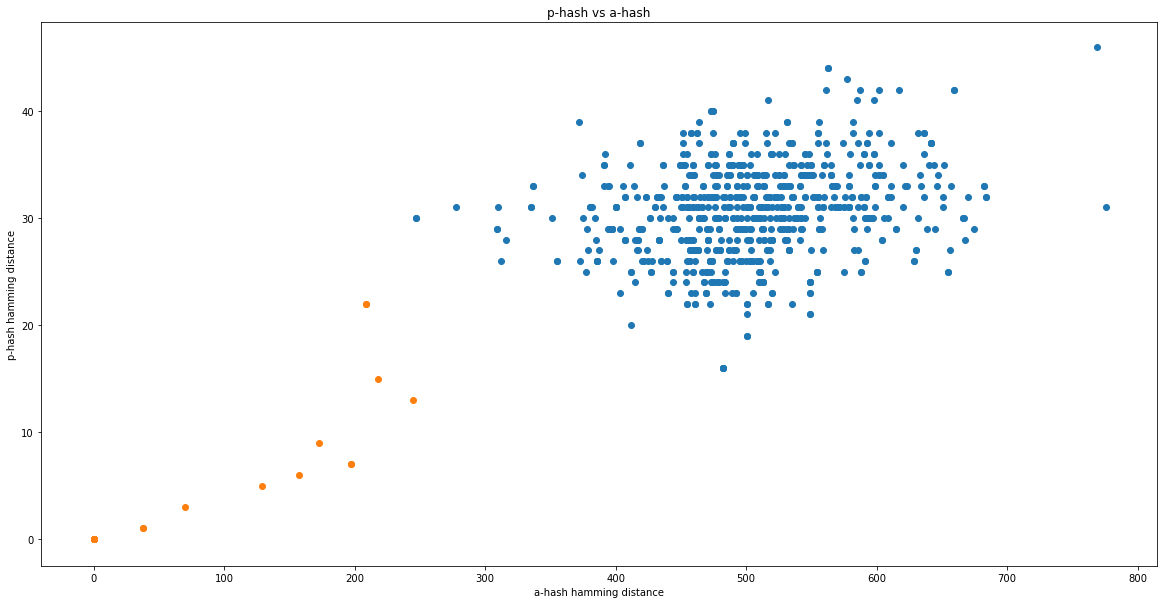

In [657]:
plt.figure(figsize=(20, 10))
plt.title('p-hash vs a-hash')
plt.xlabel('a-hash hamming distance')
plt.ylabel('p-hash hamming distance')
plt.scatter(feat[feat[:, -1] == 0][:, 3], feat[feat[:, -1] == 0][:, 6])
plt.scatter(feat[feat[:, -1] == 1][:, 3], feat[feat[:, -1] == 1][:, 6])

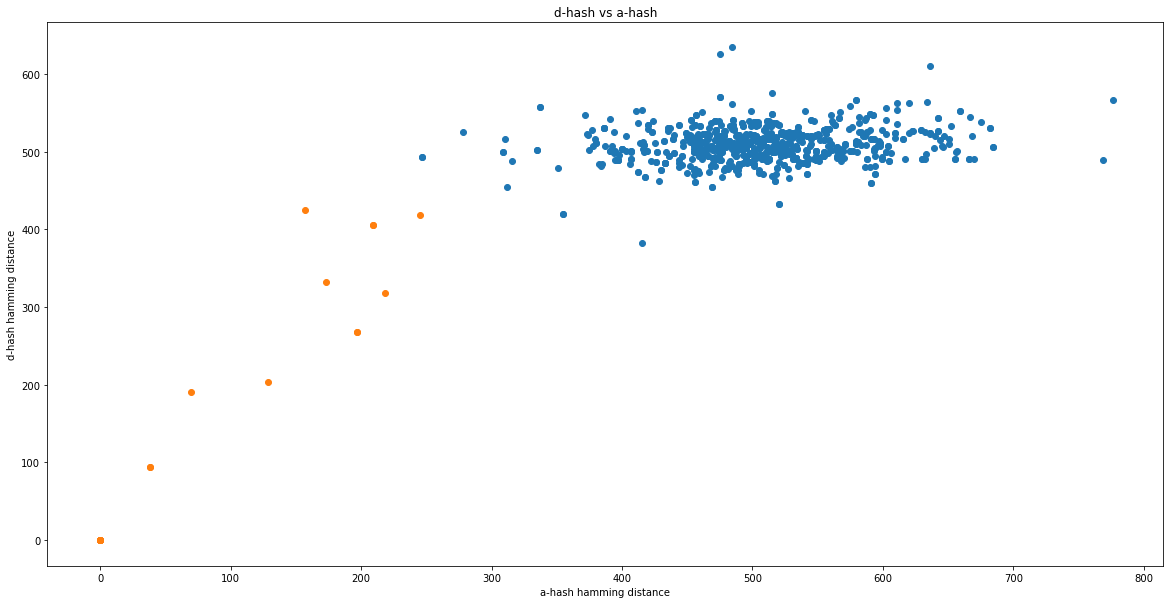

In [658]:
plt.figure(figsize=(20, 10))
plt.title('d-hash vs a-hash')
plt.xlabel('a-hash hamming distance')
plt.ylabel('d-hash hamming distance')
plt.scatter(feat[feat[:, -1] == 0][:, 3], feat[feat[:, -1] == 0][:, 5])
plt.scatter(feat[feat[:, -1] == 1][:, 3], feat[feat[:, -1] == 1][:, 5])

# Fitting Gaussian Distribution 

In [593]:
gaus = feat[:, [3, 6, -1]]

In [611]:
def prob(x, mu, cov):
    divisor = np.power(2 * np.pi, len(mu) / 2) * np.sqrt(np.linalg.det(cov))
    divident = np.exp((x - mu).T.dot(np.linalg.inv(cov)).dot(x - mu) / -2)
    return divident / divisor

In [635]:
mu = gaus[gaus[:, -1] == 0][:, :-1].mean(axis=0)
c = np.cov(gaus[gaus[:, -1] == 0][:, :-1].T)

In [646]:
x, y = np.meshgrid(np.arange(0, 800, 0.1), np.arange(0, 50, 0.1))

In [649]:
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = prob(np.array([x[i, j], y[i, j]]), mu, c)

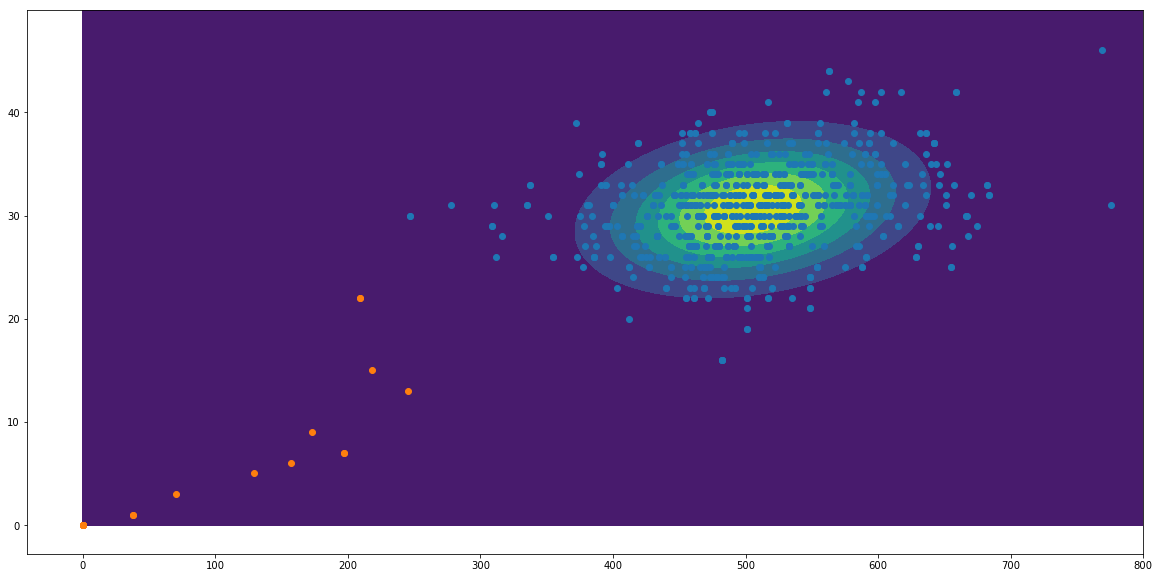

In [653]:
plt.figure(figsize=(20, 10))
plt.contourf(x,y,z)
plt.scatter(gaus[gaus[:, -1] == 0][:, 0], gaus[gaus[:, -1] == 0][:, 1])
plt.scatter(gaus[gaus[:, -1] == 1][:, 0], gaus[gaus[:, -1] == 1][:, 1])

# Ensemble

In [667]:
def classify_ensemble(im1, im2):
    return sum([
        classify_rulebased(im1, im2),
        classify_regression(im1, im2),
        classify_hashbased(im1, im2)
    ]) >= 2

# Time comparison

In [670]:
%timeit classify_hashbased(im_list[0], im_list[1])
%timeit classify_rulebased(im_list[0], im_list[1])
%timeit classify_regression(im_list[0], im_list[1])
%timeit classify_ensemble(im_list[0], im_list[1])

257 µs ± 8.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
26.1 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
55.5 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.8 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
